In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [71]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
using Test
using ForwardDiff
using NonlinearSolve
using NLsolve
using Distributions
using BenchmarkTools
using LoopVectorization

In [72]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [173]:
Nx = 3
Ne = 100

X0 = randn(Nx, Ne) .^2 .* (1.0 .+ 0.3*randn(Nx, Ne))
X = deepcopy(X0)
X .+= 0.1*randn(Nx, Ne)
B = MultiBasis(CstProHermite(6), Nx)
idx = [0 0 0 ;0  0 1; 0 1 0; 1 0 0;1 1 0; 0 1 1; 1 0 1; 6 1 1; 1 2 0; 5 1 0]
Nψ = size(idx, 1)
coeff = randn(Nψ)

f = ExpandedFunction(B, idx, coeff)
fp = ParametricFunction(f);
R = IntegratedFunction(fp)
S = Storage(fp, X);

In [179]:
F = evaluate(R, X0);

cache  = zeros(Ne, Nψ)
cache_vander = zeros(Ne, maximum(R.f.f.idx[:,Nx])+1)
fx = zeros(Ne)

# Remove f(x_{1:k-1},0) from the output F
@avx for i=1:Ne
    foffseti = zero(Float64)
    for j=1:Nψ
        foffseti += (S.ψoffψd0[i,j])*R.f.f.coeff[j]
    end
    F[i] -= foffseti
end

# lower and upper brackets of the ensemble members
xk = view(X, Nx, :)
xm = copy(xk)
xp = copy(xk)
σ = std(xm)
xm .-= 1*σ
xp .+= 1*σ
fm = zeros(Ne)
fp = zeros(Ne)
# Find a bracket for the different samples
niter = 100
factor = 1.6
counter = 0
bracketed = false
while bracketed == false
    functionalf!(fm, xm, cache, cache_vander, S.ψoff, F, R)
    functionalf!(fp, xp, cache, cache_vander, S.ψoff, F, R)
    # We know that the function is strictly increasing
    @show all(fm .< 0.0)
    @show all(fp .> 0.0)
    if all(fm .< 0.0) && all(fp .> 0.0)
        bracketed = true
        break
    end
    @inbounds for i=1:Ne 
        if fm[i]*fp[i] > 0.0
            counter += 1
            center, width = 0.5*(xp[i] + xm[i]), factor*(xp[i] - xm[i])
            xm[i] = center - width
            xp[i] = center + width
        end
    end
    counter += 1
end

@assert counter < niter "Maximal number of iterations reached"

frel = 1e-4
xrel = 1e-6

Δfmax = 1.0
Δxmax = 1.0

xnew = copy(xk)
xold = copy(xk)
J = zero(f0)
Δx = 10^6


while Δx > xrel
    # Compute the Newton update
    functionalf!(fx, xnew, cache, cache_vander, S.ψoff, F, R)
    functionalg1D!(J, xnew, cache, cache_vander, S.ψoff, F, R)
    Δx = 10^6
    @inbounds for i=1:Ne
        xnewi = xnew[i]
        xoldi = xold[i]
        fxi   = fx[i]
        Ji    = J[i]
        xmi   = xm[i]
        fmi   = fm[i]
        xpi   = xp[i]
        fpi   = fp[i]
        
        
        Δxi = abs(xnewi - xoldi)
        if Δx < Δxi
            Δx = Δxi
        end
        
        # Check if xnewton is within the bracket, otherwise apply bisection
        if xnewi > xpi || xnewi < xmi
            
        # Apply the bisection method
        xnewi, fxi, xmi, fmi, xpi, fpi = bisection(xnewi, fxi, xmi, fmi, xpi, fpi)

        
        # Decrease too slowly, revert to bisection
        elseif abs(fxi * 2.0) > abs(Δxi* Ji)
        # Apply the bisection method
        xnewi, fxi, xmi, fmi, xpi, fpi = bisection(xnewi, fxi, xmi, fmi, xpi, fpi)
                
#         elseif abs(Ji) < 1000*eps()
#         # Apply bisection
                              
#         else #Apply Newton update
#         xnew[i] -= fxi/Ji
        end
        
        xnew[i] = xnewi
        xold[i] = xoldi
        xm[i]   = xmi
        fm[i]   = fmi
        xp[i]   = xpi
        fp[i]   = fpi
    end 
end

all(fm .< 0.0) = true
all(fp .> 0.0) = true


LoadError: [91mUndefVarError: bisection not defined[39m

In [161]:
function test!(x)
    x = 1.0
    nothing
end

test! (generic function with 1 method)

In [162]:
a = 2.0
test!(a)

In [34]:
@time optimize(S, X, "kfolds"; withqr = true, hessprecond = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


116.187149 seconds (12.75 M allocations: 143.489 GiB, 4.39% gc time)


HermiteMap(20, 10, LinearTransform(10, [1.1195256465682104, 0.9728805809361984, 0.915577381173001, 0.9169390552688318, 1.024849057653465, 1.0207711546991929, 1.071957519333033, 0.9829474984141241, 1.0037238471249987, 1.0422161865737807], [2.45918785711432 0.0 … 0.0 0.0; 0.0 2.2539117629083045 … 0.0 0.0; … ; 0.0 0.0 … 2.30972952436834 0.0; 0.0 0.0 … 0.0 2.2509787353294453], true), MapComponent[Map component of dimension 1 with Nψ 14 active features
, Map component of dimension 2 with Nψ 16 active features
, Map component of dimension 3 with Nψ 20 active features
, Map component of dimension 4 with Nψ 20 active features
, Map component of dimension 5 with Nψ 19 active features
, Map component of dimension 6 with Nψ 20 active features
, Map component of dimension 7 with Nψ 20 active features
, Map component of dimension 8 with Nψ 20 active features
, Map component of dimension 9 with Nψ 20 active features
, Map component of dimension 10 with Nψ 20 active features
])

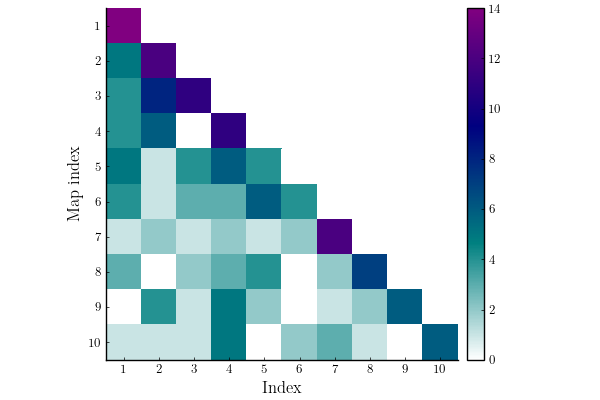

In [35]:
plot(S)

In [36]:
F = rand(Laplace(), (Nx, Ne))
F0 = deepcopy(F);

In [37]:
xrange = -5:0.01:5.0

Xrange = zeros(Nx, length(xrange))
Xrange[end,:] .= collect(xrange)
view(Xrange,1:Nx-1,:) .= repeat(randn(Nx-1), 1, length(xrange));

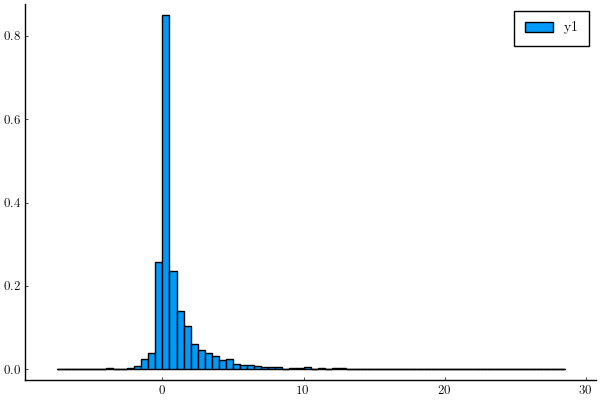

In [38]:
histogram(sort(X[end,:]),  bins = 90, normalize = :pdf)

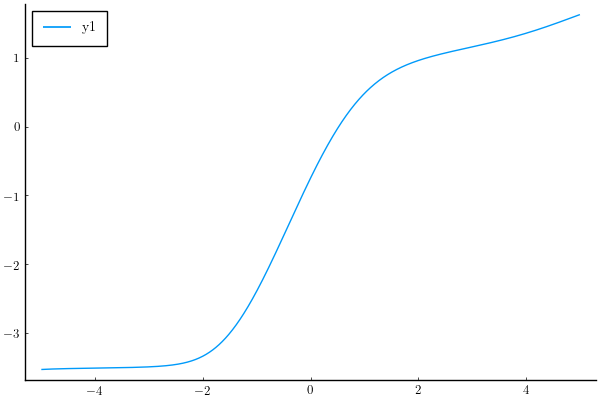

In [39]:
plot(xrange, evaluate(S, Xrange; start = Nx)[end,:])

In [123]:
Xpost = deepcopy(X)[:,1:1]
@btime inverse!(Xpost, copy(F[:,1:1]), S)

  233.605 μs (4289 allocations: 267.03 KiB)


10×1 Array{Float64,2}:
 -6.6940053024980894
  0.7813151227451507
 -0.1545225018963985
  1.5829584025685157
 -0.2182828264926049
  1.6811151650045222
  0.36005280775071213
  0.6414972076521022
  0.9728650754039316
 -0.5096409881052824

In [125]:
Xpost = deepcopy(X)
@btime inverse!(Xpost, copy(F), S)

  10.562 ms (12123 allocations: 20.68 MiB)


10×500 Array{Float64,2}:
 -6.69432    -0.325811  0.866688   …   3.99049    0.800305   -5.34821
  0.652841    1.00699   0.0709028      0.119864   0.782312    0.332934
 -0.147232    1.01834   0.130148       0.203138  -0.409091    0.863126
  1.56178     0.235563  1.70613        1.21226    0.264081    1.91235
 -0.217985    5.13841   0.250809       0.572872   0.837754   -0.478516
  1.65968    -0.510001  0.795841   …   2.53737    0.0704323   8.82153
  0.0676075  -0.318584  0.725396       1.13007   -0.111888    0.171928
  0.643154    0.987011  1.4607        -0.231542   1.15277     0.125883
  0.971018   -0.361035  1.51833        0.520839   2.40892    -5.70749
 -0.510841    0.269097  0.435094       0.625539   8.08316     0.330348

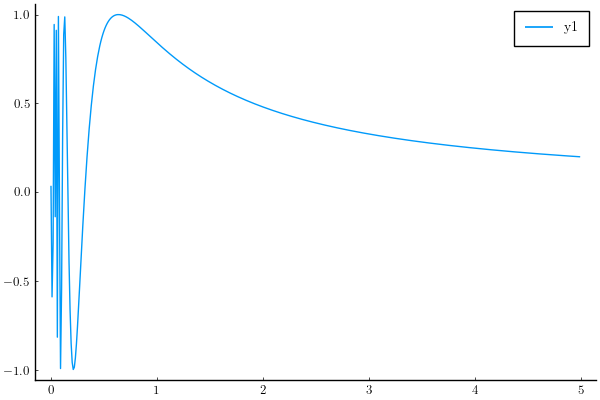

In [16]:
plot(collect(0.00001:0.01:5.0), sin.(1 ./ collect(0.00001:0.01:5.0)))

In [63]:
maximum(evaluate(S, Xpost)-F)

0.007631680483031644

In [108]:
@btime ψoff = evaluate_diagbasis(S[10].I.f, X)

  18.940 μs (40 allocations: 142.86 KiB)


500×14 Array{Float64,2}:
 0.617909     0.183069     -0.398576  1.0  …   0.236137     1.0  -0.257108
 0.00151744   0.00745327    0.024813  1.0      0.242059     1.0   0.360888
 0.605522     0.248767     -0.355901  1.0      0.302956     1.0  -0.176634
 0.630959     0.0407927    -0.444291  1.0      0.0557021    1.0  -0.3483
 0.630153     0.0607466    -0.441445  1.0      0.0826658    1.0  -0.342476
 0.230572     0.462921      0.494154  1.0  …  -0.382899     1.0  -0.101714
 0.606173     0.245843     -0.358126  1.0      0.300328     1.0  -0.180717
 0.41352      0.538263      0.20302   1.0      0.0455764    1.0   0.355185
 0.615824     0.196001     -0.391343  1.0      0.250444     1.0  -0.243147
 0.365527     0.540657      0.307002  1.0     -0.103223     1.0   0.301408
 0.631619     0.000146277  -0.446622  1.0  …   0.000200298  1.0  -0.353086
 0.44251      0.527922      0.132449  1.0      0.134593     1.0   0.355307
 0.631619    -0.00013236   -0.446622  1.0     -0.000181241  1.0  -0.353086
 ⋮

In [68]:
?nlsolve

search: nlsolve NLsolve NonlinearSolve EnsembleSolution EnsembleTestSolution



No documentation found.

`NLsolve.nlsolve` is a `Function`.

```
# 4 methods for generic function "nlsolve":
[1] nlsolve(df::Union{NLSolversBase.NonDifferentiable, OnceDifferentiable}, initial_x::AbstractArray; method, xtol, ftol, iterations, store_trace, show_trace, extended_trace, linesearch, linsolve, factor, autoscale, m, beta, aa_start, droptol) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:1
[2] nlsolve(f, initial_x::AbstractArray; method, autodiff, inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:40
[3] nlsolve(f, j, initial_x::AbstractArray; inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:56
[4] nlsolve(f, j, fj, initial_x::AbstractArray; inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:70
```
